Data Science is typically about trying to find the best model for a certain situation. Usually, "best" will mean something like "minimising the error of the model" or "maximising the likelihood of the data". In other words, it will represent the solution to some sort of optimisation problem. 

This means we'll need to solve a number of iotimisation problems. And, in particular, we'll need to solve them from scratch. Our approach will be a technique called *gradient descent*, which lends itself pretty well to a from-scratch treatment. You might not find it super-exciting in and of itself, but it will enable us to do exciting things from here on. 

In [3]:
import ipynb.fs.defs.Chapter4_LinearAlgebra as la

# The idea behind gradient descent

Suppose we have some function $f$ that takes as input a vector of real numbers and outputs a single real number. One simple function is: 

In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)


We'll frequently need to maximise or minimise such functions. That is, we need to find the input $v$ that produces the largest (or smallest) possible value. 

For functions ike ours, the $gradient$ (if you remember calculus, this is the vector of partial derivatives) gives the input direction in which the function most quickly increases. Accordingly, one approach to maximising a function is to pick a random starting point, compute the gradient, take a small step in the direction of the gradient (i.e. the direction that causes the function to increase most) and repeat with the new starting point. Similarly, you can try to minimize a function by taking small steps in the $opposite$ direction. 

## Note

If a function has a unique global minimum, this procedure is likely to find it. If a function has multiple (local) minima, this procedure might "find" the wrong one, in which case, you might need to rerun this procedure fro a variety of starting points. If a function has no minimum then it's possible the procedure might go on for ever. 

## Estimating the Gradient
If $f$ is a function of one variable, its derivative at point $x$ measures how $f(x)$ changes when we make a very small change to x. It is defined as the limit of the difference quotients:

In [3]:
def difference_quotient(f,x,h):
    return (f(x+h) - f(x)) / h

as h approaches zero. 

(Many a would-be calculus student has been stymied by the mathematical definition of the limits. Here, we'll cheat and simply say ut means what you think it means.)

The derivative is the slope of the tangent line at $(x, f(x))$, while the difference quotient is the slope of the not-quite-tangent line that runs through $(x+h, f(x+h))$. As $h$ gets smaller and smaller, the not-quite-tangent line gets closer and closer to the tangent line. 

For many functions it's easy to exactly calculate derivatives. For example, the quare function: 

In [4]:
def square(x):
    return x ** 2

has the derivative:

In [5]:
def derivative(x):
    return 2 * x 

which you can check, if you are so inclined by explicitly computing the difference quotient and taking the limit. 

What if you couldn't (or didn't want to) find the gradient? Although we can't take limits in Python, we can estimate derivatives by evaluating the difference quotient for a very small $e$.  

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


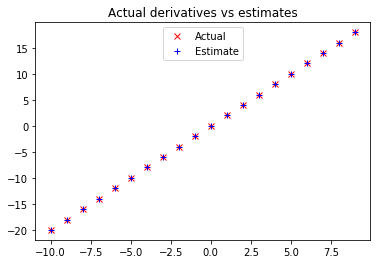

In [13]:
from functools import partial
derivative_estimate = partial(difference_quotient, square, h=0.0001)

# plot to show they're basically the same..
import matplotlib.pyplot as plt
x = range(-10, 10)
actual_y = list(map(derivative,x))
estimated_y = list(map(derivative_estimate, x))

print(actual_y)
plt.title("Actual derivatives vs estimates")
plt.plot(x, actual_y, 'rx', label='Actual')              # red x
plt.plot(x, estimated_y, 'b+', label='Estimate')   # blue +
plt.legend(loc=9)
plt.show()

When $f$ is a function of many variables, it has many *partial derivatives*, each indicating how $f$ changes when we make small chanhes in just one of the input variables. 

We calculate its *i*th partial derivative by treating it as a function of just its *i*th variable, holding other variables as fixed:

In [14]:
def partial_difference_quotient(f, v, i, h):
    """compute the ith partial derivative quotient of f at v"""
    v = [v_j + (h if j ==1 else 0)         # add h to just the ith element of v
        for j, v_j in enumerate(v)]
    
    return (f(v) - f(v)) / h

after which we can estimate the gradient the same way

In [15]:
def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f,v,i,h)
           for i, _ in enumerate(v)]

## Note

A major drawback to the "estimate using difference quotients" approach is that it's computationally expensive. If v has a length n, estimate_gradient has to evaluate f on 2n different inputs. If you're repeatedly estimating gradients, you're doing a whole lot of extra work.. 

# Using the gradient

It's easy to see that the $sum_of_squares$ function is smallest when its input $v$ is a vector of zeroes. But imagine we didn't know that. Let's use gradients to find the minimum among all three-dimensiona;l vectors. We'll just pick a randm starting point and then take tiny steps in the opposite direction of the gradient until we reach a point where the gradient is very small:   

In [7]:
import random

def step (v, direction, step_size):
    """move step_size in the direction from V"""
    return [v_i + step_size * direction_i
           for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# Pick a random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v)   # calculate gradient at v
    next_v = step(v, gradient, -0.01)       # take a negative gradient step
    if la.distance(next_v, v) < tolerance:     # stop if we're converging
        print(next_v)
        break
    v = next_v                              # otherwise repeat again

[3.4664989081760563e-06, 1.7332494540880281e-06, -2.8887490901467167e-06]


Running the code above always produces a v that's very close to zero. The smaller the tolerance, the closer it gets. 

## Choosing the Right Step Size

Although the rationale for moving against the gradient is clear, how vfar to move is not. Indeed, choosing the right step size is more of an art than a science. Some popular options include: 
- Using a fixed size
- Gradually shrinking the step size over time
- At each step, choosing the step size that minimises the value of the objective function. 

The last sounds optimal but is, in practice a costly computation. We can approximate it by trying a variety of step sizes and choosing the one that results in the smallest value of the objective function:

In [8]:
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

It is possible that certain step sizes will result in invalid inputs for our function. So we'll need to create a "safe apply" function that returns infinity (which should never be the minimum value of anything) for invalid inputs: 

In [ ]:
def safe(f):
    """ return a new function that is the same as f except it returns infinity
    in any scenario that f produces an error """
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')    # The python representation of infinity
        
    return safe_f


## Putting it all together.

In the general case, we'll have some $target_fn$  that we want to minimise and we also have its $gradient_fn$. For example, the $target_fn$ could represent errors in a model as a function of its parameters and we may want to find the vaue of the parameters that make the errors as small as possible. 

Furthermore, let's say we have somehow chosen a starting point for the paranmeters $theta_0$. Then we can implement gradient descent as:

In [ ]:
def minimise_batch(target_fn, gradient_fn, theta_0, tolerance=0.0000001):
    """use gradient descent to tind the theta that minimises the target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    theta = theta_0      # set the starting value
    target_fn = safe(target_fn)  # safe version of target function
    value = target_fn(theta)     # value we're minbimising
    
    while True: 
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                           for step_size in step_sizes] 
        
        # Choose the one that minimises the error function
        next_theta = min(next_thetas, key=tagret_fn)
        next_value = target_fn(next_theta)
        
        # stop if we're converging
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
        

We called it $minimise_batch$ because, for each gradient step it looks across the entire dataset (because $target_fn$ returns the error on the whole dataset). In the next section, we'll see an alternative approach that only looks at one data point at a time. 

Sometimes we'll instead want to *maximise* a function, which we can do by minimising the negative value. this has a corresponding negative gradient: 


In [9]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximise_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimise_batch(negate(target_fn), 
                         negate_all(gradient_fn),
                         theta_0,
                         tolerance)

# Stochastic Gradient Descent

Gradient descent is often used to choose the parameters of a model in such a way to minimise the notional error. Using the previous approach, each gradient step requires a prediction and compute the gradient for the dataset as a whole, which means each step takes a long time. 

Now, usually, these error functions are *additive*,meaning the predictive error on the whole dataset is simply the sum of the predictive errors for each point. 

When this is the case, we can instead apply a technique called *stochastic gradient descent* which computes the gradient and takes a step for only one poin at a time. It cycles over the data repeadedly until it reaches a stopping point. 

During each cycle, we'll iterate through the data set in a random order

In [ ]:
def in_random_order(data):
    """generator that redturns elements from a data set in random order"""
    indexes = [i for i, _ in enumerate(data)]    # create a list of indexes
    random.shuffle(indexes)                      # shuffle the indexes
    for i in indexes:                            # return data in that randomised order
        yield data[i]
        

And, we'll want to take a gradient step for each data point. This approach leaves the possibility that we might circle around near a minimum forever, so whenever we stop getting improvements, we'll decrease the step size, then eventually stop iterating. 

In [10]:
def minimise_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0 = 0.01):
    
    data = zip(x,y)
    theta = theta_0                   # initial guess
    alpha = alpha_0                   # initial step size
    min_theta, min_value = None, float('inf')  # store current minimum
    iterations_with_no_improvement = 0
    
    # if we go over 100 iterations with no improvement, stop. 
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data )
        
        if value <min_value:
            # found a new minimum- store it 
            # use the original step size. 
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
            
        else:
            # otherwise, not improving, so shrink step size. 
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        for x_i, y_i in random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = la.vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta

The stochastic functiona will typically be much faster than the batch version. Of cource, we'll need a maximise function, too.. 

In [12]:
def maximise_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimise_stochastic(negate(target_fn), 
                              negate_all(gradient_fn), 
                              x, y, theta_0, alpha_0)
